# Machine Learning Experiments with Sacred



## About me

### Hi, I am Rüdiger

### GitHub: JarnoRFB

<br/>
<div style="float:left">
<div style="width: 35%; float:left">
<img src="http://computational-cognition.eu/files/header.jpg"/>
    <p><b>Neuroinformatics Group Osnabrück</b></p>
</div>
<div style="width: 55%;float:right">
<img src="http://www.sialon.eu/data2/images/63_Logo_Germany_RobertKoch.jpg"/>
</div>
</div>

## Let's try to solve a classic machine learning problem!
* Let's take the breast cancer dataset from scikit-learn.
* It describes 30 numeric features of the cell nuclei. 
* The target is to figure out, whether the cells are benign or a malignant turmor.

In [1]:
import os
import pandas as pd
from sklearn import svm, datasets, model_selection

In [2]:
dataset = datasets.load_breast_cancer()
data = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Nothing easier than that! We just split the data into training and test set, and throw a standard Support Vector Machine at the problem. 

In [3]:
X, y = datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

clf = svm.SVC(C=5, kernel="rbf", gamma=0.9)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.631578947368421

Next we try to tune the parameters a bit to get optimal performance.

However, after some time we start to forget what combinations we tried already and what the actual results where...

## Sacred to the rescue


> Every experiment is sacred <br/>
> Every experiment is great <br/>
> If an experiment is wasted <br/>
> God gets quite irate <br/>

 &mdash; Modified after *Monty Python's The Meaning of Life*
 
[sacred](https://github.com/IDSIA/sacred) is a library that helps you to keep track of your machine learning experiments.

In [4]:
from sacred import Experiment

ex = Experiment(
    name="svm", 
    interactive=True,  # Because we are running in IPython.
)

In [5]:
@ex.config
def cfg():
    C = 1.0
    gamma = 0.7
    kernel = "rbf"
    seed = 42  # Add a seed to the config for more determinism.


In [6]:
@ex.main
def run(C, kernel, gamma):
    X, y = datasets.load_breast_cancer(return_X_y=True)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

    clf = svm.SVC(C, gamma=gamma, kernel=kernel)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [7]:
ex.run()

WARNING - svm - No observers have been added to this run
INFO - svm - Running command 'run'
INFO - svm - Started
INFO - svm - Result: 0.6228070175438597
INFO - svm - Completed after 0:00:00


## Modularizing using captured functions

The `ex.capture` decorator injects the config into the function. We can call caputured functions without explicitly passing the arguments later on.

In [8]:
ex = Experiment('svm', interactive=True)

@ex.config
def cfg():
    C = 1.0
    gamma = 0.7
    kernel = 'rbf'
    seed = 42
    
@ex.capture
def get_model(C, gamma, kernel):
    return svm.SVC(C=C, kernel=kernel, gamma=gamma)
    
@ex.main
def run():  # Now we don't have to pass parameters to run anymore.
    X, y = datasets.load_breast_cancer(return_X_y=True)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
    clf = get_model()  # Parameter from the config are automatically injected.
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

ex.run()

WARNING - svm - No observers have been added to this run
INFO - svm - Running command 'run'
INFO - svm - Started
INFO - svm - Result: 0.6228070175438597
INFO - svm - Completed after 0:00:00


## Adding Observers
By adding observers, we can store configurations and results of experiments into a database, preferably MongoDB.

In [9]:
# Load some environment variables, to match the docker environment.
from dotenv import load_dotenv
env_path = 'sacred_setup_protected/.env'
load_dotenv(dotenv_path=env_path)

True

In [10]:
# If you use the protected setup.
db_name = os.environ['MONGO_DATABASE']
mongo_uri = (f'mongodb://{os.environ["MONGO_INITDB_ROOT_USERNAME"]}:'
             f'{os.environ["MONGO_INITDB_ROOT_PASSWORD"]}@localhost:27017/?authMechanism=SCRAM-SHA-1')

In [11]:
# If you use the unprotected setup just running on localhost.
db_name = "pydata_berlin"
mongo_uri = None

In [12]:
from sacred.observers import MongoObserver

ex = Experiment('svm', interactive=True)

ex.observers.append(
    MongoObserver.create(
        url=mongo_uri,
        db_name=db_name,
    )
)

In [13]:
@ex.config
def cfg():
    C = 1.0
    gamma = 0.7
    kernel = 'rbf'
    seed = 42
    
@ex.main
def run(C, kernel, gamma):
    X, y = datasets.load_breast_cancer(return_X_y=True)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

    clf = svm.SVC(C, gamma=gamma, kernel=kernel)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

ex.run()
# The "No observers have been added to this run" warning vanishes.

INFO - svm - Running command 'run'
INFO - svm - Started run with ID "3"
INFO - svm - Result: 0.6228070175438597
INFO - svm - Completed after 0:00:00


Now we can view the result in a dashboard like [Omniboard](https://github.com/vivekratnavel/omniboard). Go to http://localhost:9000/ to see the how it looks.

## Recording metrics and artifacts
We can attach metrics and even entire files as artifacts to our experiments.

In [14]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix


def plot_confusion_matrix(confusion_matrix, class_names):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig, ax = plt.subplots()
    heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues")
    heatmap.set(ylabel='True label', xlabel='Predicted label')

    return fig

In [15]:
ex = Experiment('svm', interactive=True)

ex.observers.append(MongoObserver.create(
    url=mongo_uri,
    db_name=db_name))

@ex.config
def cfg():
    C = 1.0
    gamma = 0.7
    kernel = 'linear'  # Try out a different kernel.
    seed = 42
    
@ex.capture
def get_model(C, gamma, kernel):
    return svm.SVC(C=C, kernel=kernel, gamma=gamma)

INFO - svm - Running command 'run'
INFO - svm - Started run with ID "4"
INFO - svm - Result: 0.956140350877193
INFO - svm - Completed after 0:00:01


Added image/png as content-type of artifact /home/jarno/projects/pydata_berlin_sacred/confusion_matrix.png.


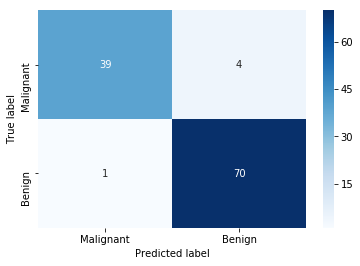

In [16]:
@ex.main
def run(C, kernel, gamma, _run):
    X, y = datasets.load_breast_cancer(return_X_y=True)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

    clf = get_model()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Plot the confusion matrix and store it as PNG.             
    cm_filename = 'confusion_matrix.png' 
    confusion = confusion_matrix(y_test, y_pred, labels=[False, True])
    fig = plot_confusion_matrix(confusion, class_names=['Malignant', 'Benign'])
    fig.savefig(cm_filename)
    # Save the artifact.
    _run.add_artifact(cm_filename)
    
    # Save the F1 score as a metric.
    _run.log_scalar('F1', f1_score(y_test, y_pred))
             
    return clf.score(X_test, y_test)

ex.run()

## Retrieving results using incense
Once we are done conducting our experiments, we can get the results back into Python using [incense](https://github.com/JarnoRFB/incense). This is especially useful for organizing results in a comprehensive way.

In [17]:
from incense import ExperimentLoader

loader = ExperimentLoader(
    mongo_uri=mongo_uri,
    db_name=db_name,
)

In [18]:
exp = loader.find_by_id(1)
exp

Experiment(id=1, name=svm)

In [19]:
exp.config

pmap({'kernel': 'rbf', 'gamma': 0.7, 'C': 1.0, 'seed': 42})

In [20]:
exp.result

0.6228070175438597

In [21]:
exp = loader.find_by_config_key('kernel', 'linear')[0]
exp

Experiment(id=2, name=svm)

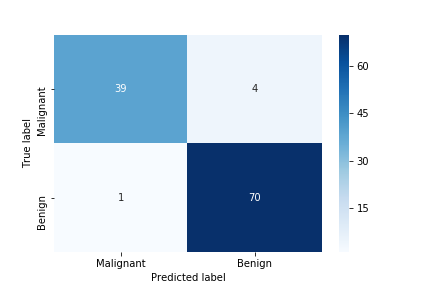

In [22]:
exp.artifacts['confusion_matrix.png'].render()

In [23]:
loader.find_all().project(on=["config.kernel","result"])

,kernel,result
exp_id,,
1,rbf,0.622807
2,linear,0.956140
3,rbf,0.622807
4,linear,0.956140


In [24]:
exp.metrics["F1"]

step
0    0.965517
Name: F1, dtype: float64

## Some powerful usage patterns

## Configurations from files
Instead of defining your configuration in a Python function you can outsource it to a JSON or YAML file.

In [ ]:
# %load config.json
{
  "C": 1.0,
  "gamma": 0.7,
  "kernel": "rbf",
  "seed": 42
}


In [25]:
from sacred.observers import MongoObserver

ex = Experiment("svm", interactive=True)

ex.observers.append(
    MongoObserver.create(
        url=mongo_uri,
        db_name=db_name,
    )
)

ex.add_config("config.json")  # Load the config from a file.

@ex.main
def run(C, kernel, gamma):
    X, y = datasets.load_breast_cancer(return_X_y=True)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

    clf = svm.SVC(C, gamma=gamma, kernel=kernel)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

ex.run()

INFO - svm - Running command 'run'
INFO - svm - Started run with ID "5"
INFO - svm - Result: 0.6228070175438597
INFO - svm - Completed after 0:00:00


## Invoking experiments from the command line

In [ ]:
# %load experiment.py
import os

from sacred import Experiment
from sacred.observers import MongoObserver
from sklearn import svm, datasets, model_selection
from dotenv import load_dotenv


db_name = "pydata_berlin"
mongo_uri = None

ex = Experiment('svm')

ex.observers.append(
    MongoObserver.create(
        url=mongo_uri,
        db_name=db_name,
    )
)

     
@ex.config
def cfg():
    C = 1.0
    gamma = 0.7
    kernel = "rbf"
    seed = 42


@ex.capture
def get_model(C, gamma, kernel):
    return svm.SVC(C=C, kernel=kernel, gamma=gamma)

           
@ex.automain # Use automain to enable command line integration.
def run():
    X, y = datasets.load_breast_cancer(return_X_y=True)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
    clf = get_model()
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)


In [26]:
!python experiment.py

INFO - svm - Running command 'run'
INFO - svm - Started run with ID "6"
INFO - svm - Result: 0.6228070175438597
INFO - svm - Completed after 0:00:00


In [27]:
!python experiment.py with kernel=linear

INFO - svm - Running command 'run'
INFO - svm - Started run with ID "7"
INFO - svm - Result: 0.956140350877193
INFO - svm - Completed after 0:00:01


In [28]:
!python experiment.py with config.json

INFO - svm - Running command 'run'
INFO - svm - Started run with ID "8"
INFO - svm - Result: 0.6228070175438597
INFO - svm - Completed after 0:00:00


## Modularizing using dynamic imports

In [ ]:
# %load config_svm.json
{
    "model": {
        "path": "sklearn.svm.SVC",
        "hyperparameters":{
            "C": 1,
            "gamma": 0.7,
            "kernel": "rbf"
        }
    }
}

In [ ]:
# %load experiment_dynamic.py
import os
from importlib import import_module  # For dynamic imports.

from sacred import Experiment
from sacred.observers import MongoObserver
from sklearn import svm, datasets, model_selection
from dotenv import load_dotenv

db_name = "pydata_berlin"
mongo_uri = None

ex = Experiment('svm')

ex.observers.append(
    MongoObserver.create(
        url=mongo_uri,
        db_name=db_name,
    )
)

             
def load(path):
    """Load a class, given its fully qualified path."""
    p, m = path.rsplit('.', 1)
    module = import_module(p)
    class_or_method = getattr(module, m)
    return class_or_method
     

@ex.capture(prefix="model")  # Prefix to only get the relevant subset of the config.
def get_model(path, hyperparameters):
    Model = load(path)  # Import model class dynamically.
    return Model(**hyperparameters)  # Instantiate with hyperparameters.

           
@ex.automain # Use automain to enable command line integration.
def run():
    X, y = datasets.load_breast_cancer(return_X_y=True)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
    clf = get_model()
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)


In [29]:
!python experiment_dynamic.py --name svm with config_svm.json 

WARNING - root - Added new config entry: "model.hyperparameters.C"
WARNING - root - Added new config entry: "model.hyperparameters.gamma"
WARNING - root - Added new config entry: "model.hyperparameters.kernel"
WARNING - root - Added new config entry: "model.path"
INFO - svm - Running command 'run'
INFO - svm - Started run with ID "9"
INFO - svm - Result: 0.6052631578947368
INFO - svm - Completed after 0:00:00


In [37]:
# %load config_bayes.json 
{
    "model": {
        "path": "sklearn.naive_bayes.MultinomialNB",
        "hyperparameters":{
            "alpha": 1
        }
    }
}

{'model': {'path': 'sklearn.naive_bayes.MultinomialNB',
  'hyperparameters': {'alpha': 1}}}

In [30]:
!python experiment_dynamic.py --name naive_bayes with config_bayes.json 

WARNING - root - Added new config entry: "model.hyperparameters.alpha"
WARNING - root - Added new config entry: "model.path"
INFO - naive_bayes - Running command 'run'
INFO - naive_bayes - Started run with ID "10"
INFO - naive_bayes - Result: 0.9210526315789473
INFO - naive_bayes - Completed after 0:00:00


In [39]:
# %load config_random_forrest.json
{
    "model": {
        "path": "sklearn.ensemble.RandomForestClassifier",
        "hyperparameters":{
            "n_estimators": 20,
            "criterion": "gini"
        }
    }
}

{'model': {'path': 'sklearn.ensemble.RandomForestClassifier',
  'hyperparameters': {'n_estimators': 20, 'criterion': 'gini'}}}

In [31]:
!python experiment_dynamic.py --name random_forrest with config_random_forrest.json 

WARNING - root - Added new config entry: "model.hyperparameters.criterion"
WARNING - root - Added new config entry: "model.hyperparameters.n_estimators"
WARNING - root - Added new config entry: "model.path"
INFO - random_forrest - Running command 'run'
INFO - random_forrest - Started run with ID "11"
INFO - random_forrest - Result: 0.9649122807017544
INFO - random_forrest - Completed after 0:00:00


The the SciPy talk for more information https://youtu.be/qqg7RO0o1OE

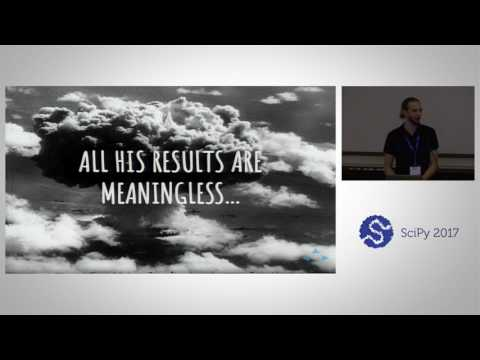

In [32]:
from IPython.display import YouTubeVideo
YouTubeVideo("qqg7RO0o1OE", width=800, height=400)

## Conclusion
Don't waste time and resources on unreproducible experiments! Sacred will give you the necessary structure to find out which machine learning models are the right ones for you.  

## Contributing
Issues, feature and pull requests highly welcome! Just go to https://github.com/IDSIA/sacred

## Thanks!

## Questions?